In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf,pacf
%matplotlib inline


/Users/williammeng/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [94]:
df = pd.read_csv('P2training.csv',header=0)
df.tail()

,Date,AUD/USD,GBP/USD,CAD/USD,NLG/USD,FRF/USD,DEM/USD,JPY/USD,CHF/USD
4014,1995-12-22,1.352265,0.648298,1.3637,1.6105,4.9340,1.4386,102.60,1.1592
4015,1995-12-26,1.351351,0.642880,1.3613,1.6045,4.9110,1.4335,102.38,1.1560
4016,1995-12-27,1.337256,0.641026,1.3601,1.6020,4.8855,1.4310,102.80,1.1530
4017,1995-12-28,1.342282,0.649773,1.3605,1.6111,4.9200,1.4420,102.87,1.1565
4018,1995-12-29,1.345533,0.643708,1.3655,1.6035,4.8975,1.4345,103.28,1.1540


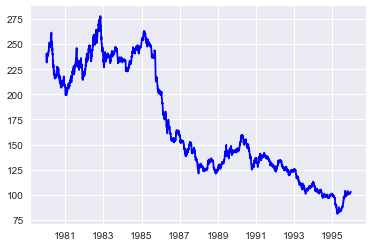

In [6]:
Date = pd.to_datetime(df.Date)
JPY = df['JPY/USD']
#fig = plt.figure(figsize=(12,9))
ax = plt.plot(Date,JPY,color = 'blue')

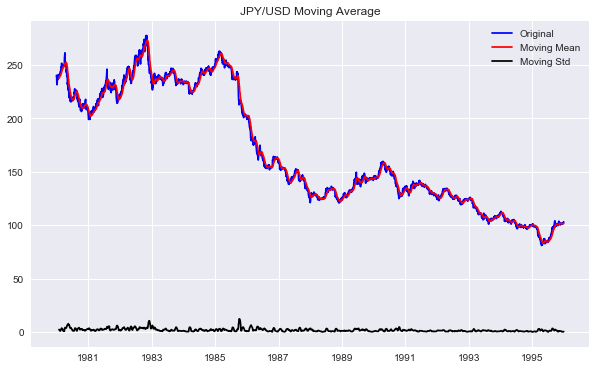

In [12]:
# plot the moving average/std with window size = period
moving = JPY.rolling(window=21, min_periods=None, freq=None, center=False)
#Plot rolling statistics:
fig = plt.figure(figsize=(10,6))
orig = plt.plot(Date, JPY, color='blue',label='Original')
mean = plt.plot(Date, moving.mean(), color='red', label='Moving Mean')
std = plt.plot(Date, moving.std(), color='black', label = 'Moving Std')
plt.legend(loc='best')
plt.title('JPY/USD Moving Average')
plt.show()

In [177]:
#plot single smoothing plot
def single_exponential_smoothing(series, alpha):
    result =[series[0]]
    for n in range(1, len(series)):
        result.append(alpha*series[n]+(1 - alpha)*result[n-1])
    return result


In [284]:
JPYdifferent = JPY - JPY.shift(1)
JPYdifferent.dropna(inplace=True)
JPYdifferent = list(JPYdifferent)
JPYdifferent = pd.Series(JPYdifferent)
a =1
rsingle = single_exponential_smoothing(JPYdifferent,a)
pred =[]
for day in range(0,len(rsingle),1):
    pred.append(rsingle[day]+JPY[day])

pred= pd.Series(pred)

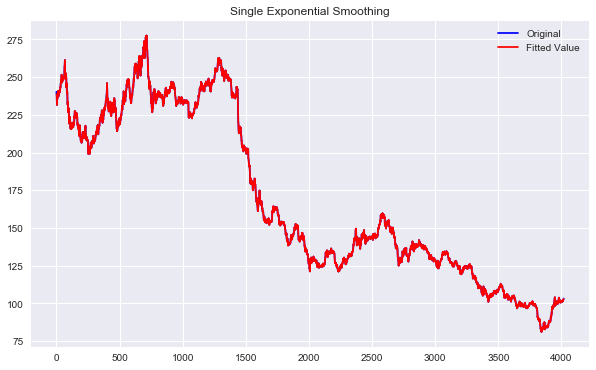

In [285]:
predvalue = pred.shift(1)
predvalue.dropna(inplace =True)
fig = plt.figure(figsize=(10,6))
orig = plt.plot(JPY, color='blue',label='Original')
mean = plt.plot(predvalue, color='red', label='Fitted Value')
plt.legend(loc='best')
plt.title('Single Exponential Smoothing')
plt.show()

In [286]:
predvalue = pred
#print JPY
#predvalue.dropna(inplace =True)
a =pd.Series(predvalue)
k=[]
for i in range(0,len(JPY)-1,1):
    k.append(JPY[i+1]-a[i])
k = pd.Series(k)
s = (k**2).sum()
print s

0.0


0.01
1738.60509827


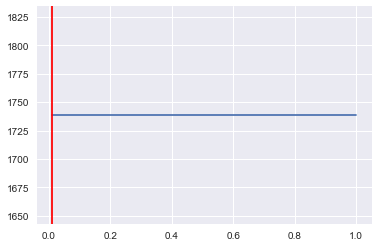

In [268]:
# find the best alpha
alpha = np.linspace(0.01,1,100)
err1=[]
JPYdifferent = JPY - JPY.shift(1)
JPYdifferent.dropna(inplace=True)
JPYdifferent = list(JPYdifferent)
JPYdifferent = pd.Series(JPYdifferent)
for a in alpha:
    single = single_exponential_smoothing(JPYdifferent,a) 
    pred =[]
    for day in range(0,len(rsingle),1):
        pred.append(rsingle[day]+JPY[day])
    a =pd.Series(pred)
    k=[]
    for i in range(0,len(JPY)-1,1):
        k.append(JPY[i+1]-a[i])
    k = pd.Series(k)
    err1.append((k**2).sum())

plt.plot(alpha, err1)
optal = alpha[np.argmin(err1)]
plt.axvline(x=optal, color='red')
print(optal)
print np.min(err1)

1.0
5372.5592


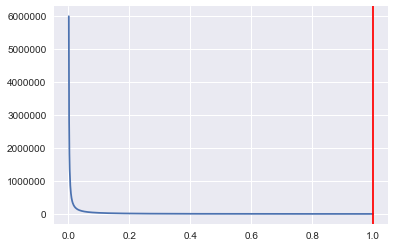

In [170]:
# find the best alpha
alpha = np.linspace(0.001,1,1000)
err1=[]
for a in alpha:
    single = single_exponential_smoothing(JPY,a) 
    dfsingle = pd.Series(single)
    diff = JPY - dfsingle.shift(1)
    e = (diff ** 2).sum()
    err1.append(e)

plt.plot(alpha, err1)
optal = alpha[np.argmin(err1)]
plt.axvline(x=optal, color='red')
print(optal)
print np.min(err1)

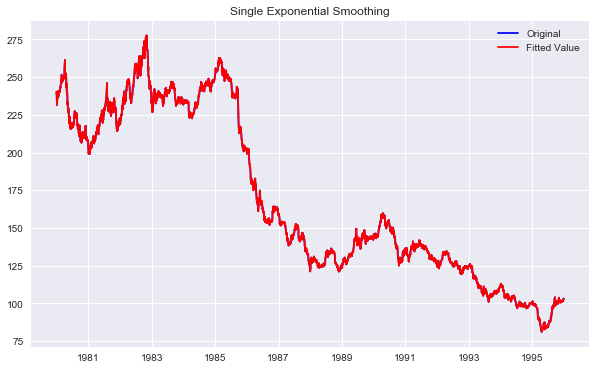

5372.5592


In [295]:
#plot exponential smoothing plot
al = 1
result = single_exponential_smoothing(JPY,al)
fig = plt.figure(figsize=(10,6))
orig = plt.plot(Date, JPY, color='blue',label='Original')
mean = plt.plot(Date, result, color='red', label='Fitted Value')
plt.legend(loc='best')
plt.title('Single Exponential Smoothing')
plt.show()

dfresult = pd.Series(result)
diff = JPY - dfresult.shift(1)
SSE = (diff ** 2).sum()
print SSE


In [294]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # when doing forecast
          value = result[-1]
        else:
          value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

182.582123056


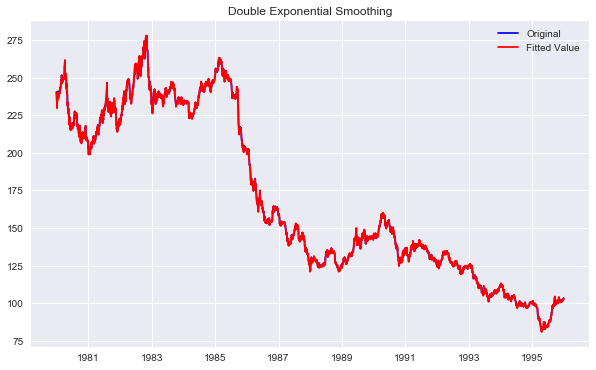

In [354]:
# double smoothing
alpha = 1
beta = 0.03
result = double_exponential_smoothing(JPY,alpha,beta)
#calculate SSE
dfresult = pd.Series(result)
diff = JPY - dfresult[0:len(JPY)]
SSE = (diff ** 2).sum()
print SSE

fig = plt.figure(figsize=(10,6))
orig = plt.plot(Date,JPY, color='blue',label='Original')
mean = plt.plot(Date,dfresult[0:len(JPY)], color='red', label='Fitted Value')
plt.legend(loc='best')
plt.title('Double Exponential Smoothing')
plt.show()

0.03


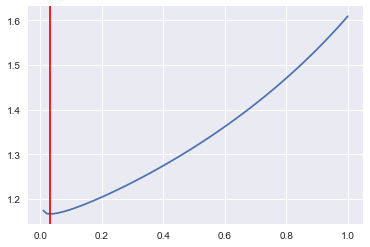

In [152]:
# find the best beta
b = np.linspace(0.01,1,100)
a = 1
err2=[]
for bi in b:
    r= double_exponential_smoothing(JPY,a,bi)
    rdf = pd.Series(r)
    diff = JPY - rdf.shift(1)
    err2.append(np.sqrt((diff ** 2).mean()))

plt.plot(b, err2)
optal = b[np.argmin(err2)]
plt.axvline(x=optal, color='red')
print(optal) 

1.0 0.1


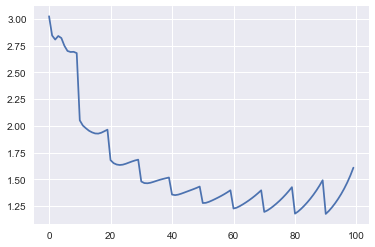

In [288]:
# find the best beta, alpha
b = np.linspace(0.1,1,10)
a = np.linspace(0.1,1,10)
err2=[]
t = 10000
l = 0
m = 0
for ai in a:
    for bi in b:
        r= double_exponential_smoothing(JPY,ai,bi)
        rdf = pd.Series(r)
        diff = JPY - rdf.shift(1)
        mse = np.sqrt((diff ** 2).mean())
        err2.append(mse)
        if mse < t:
            t = mse
            m =bi
            l =ai
print l, m
plt.plot(err2)
#optal = b[np.argmin(err2)]
#plt.axvline(x=optal, color='red')
#print(optal) 

In [84]:
#Grisha Trubetskoy

def initial_trend(series, L):
    sum = 0.0
    for i in range(L):
        sum += float(series[i+L] - series[i]) / L
    return sum / L

def initial_seasonal_components(series, L):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/L)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[L*j:L*j+L])/float(L))
    # compute initial values
    for i in range(L):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[L*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, L, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, L)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, L)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%L])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%L]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%L] = gamma*(val-smooth) + (1-gamma)*seasonals[i%L]
            result.append(smooth+trend+seasonals[i%L])
    return result

0.57


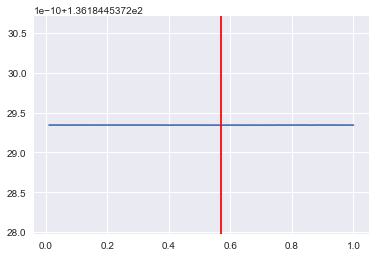

In [341]:
# find best gamma
alpha = 1
beta = 0.03
gamma = np.linspace(0.01,1,100)
L = 251
n_preds = 1
err3=[]
for g in gamma:
    result = triple_exponential_smoothing(JPY,L,alpha,beta,g,n_preds)
    dfresult = pd.Series(result)
    diff = JPY - dfresult[0:len(JPY)]
    err3.append((diff ** 2).sum())
    
plt.plot(gamma, err3)
optal = gamma[np.argmin(err3)]
plt.axvline(x=optal, color='red')
print(optal)


50.0


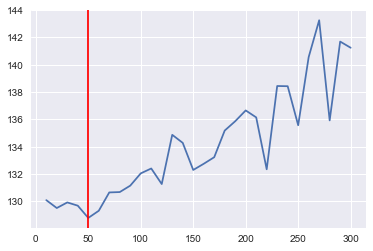

In [325]:
# find best gamma
#L = 251
alpha = 1
beta = 0.03
#gamma = np.linspace(0.01,1,100)
g = 0.5
NL = np.linspace(10,300,num=30)
n_preds = 1
err3=[]
for L in NL:
    L = np.int(L)
    result = triple_exponential_smoothing(JPY,L,alpha,beta,g,n_preds)
    dfresult = pd.Series(result)
    diff = JPY - dfresult[0:len(JPY)]
    err3.append((diff ** 2).sum())
    
plt.plot(NL, err3)
optal = NL[np.argmin(err3)]
plt.axvline(x=optal, color='red')
print(optal)

79.0


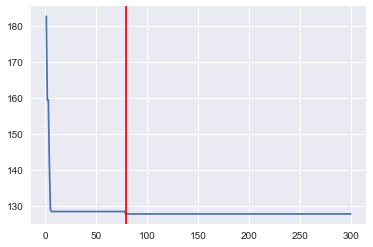

In [332]:
# find best L & gamma
#L = 251
alpha = 1
beta = 0.03
gamma = np.linspace(0.2,1,5)
#g = 0.7
NL = np.linspace(1,300,300)
n_preds = 1
err3=[]
temp = 100000
for L in NL:
    L = np.int(L)
    for g in gamma:
        result = triple_exponential_smoothing(JPY,L,alpha,beta,g,n_preds)
        dfresult = pd.Series(result)
        diff = JPY - dfresult[0:len(JPY)]
        sse = (diff ** 2).sum()
        if temp > sse:
            temp =sse
    err3.append(temp)
plt.plot(NL, err3)
optal = NL[np.argmin(err3)]
plt.axvline(x=optal, color='red')
print(optal)

127.697487118


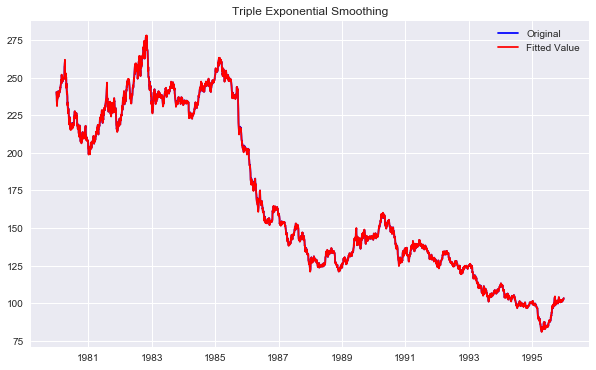

In [351]:
L = 79
#err3=[]
alpha = 1
beta = 0.03
gamma = 0.09
n_preds = 1
result = triple_exponential_smoothing(JPY,L,alpha,beta,gamma,n_preds)
dfresult = pd.Series(result)
diff = JPY - dfresult[0:len(JPY)]
SSE = (diff ** 2).sum()
print SSE
#err3.append(SSE)

# plot 
fig = plt.figure(figsize=(10,6))
orig = plt.plot(Date, JPY, color='blue',label='Original')
mean = plt.plot(Date, dfresult[0:len(JPY)], color='red', label='Fitted Value')
plt.legend(loc='best')
plt.title('Triple Exponential Smoothing')
plt.show()


In [350]:
n =len(JPY)
AIC = n*np.log(SSE/n)+4
print AIC

-13858.0306003


In [353]:
#print dfresult
print JPY

0       240.30
1       238.45
2       238.35
3       234.80
4       231.55
5       234.75
6       234.95
7       235.80
8       236.05
9       236.20
10      239.65
11      238.15
12      239.90
13      239.65
14      241.00
15      239.70
16      237.25
17      239.35
18      239.60
19      240.22
20      239.35
21      239.50
22      239.33
23      240.45
24      240.29
25      240.10
26      240.10
27      240.09
28      241.65
29      241.40
         ...  
3989    102.15
3990    102.03
3991    101.35
3992    101.63
3993    100.50
3994    101.50
3995    101.80
3996    101.12
3997    101.46
3998    101.80
3999    101.20
4000    101.05
4001    101.42
4002    101.37
4003    101.40
4004    100.95
4005    101.07
4006    101.85
4007    101.75
4008    101.50
4009    102.14
4010    101.70
4011    101.85
4012    102.00
4013    101.81
4014    102.60
4015    102.38
4016    102.80
4017    102.87
4018    103.28
Name: JPY/USD, Length: 4019, dtype: float64


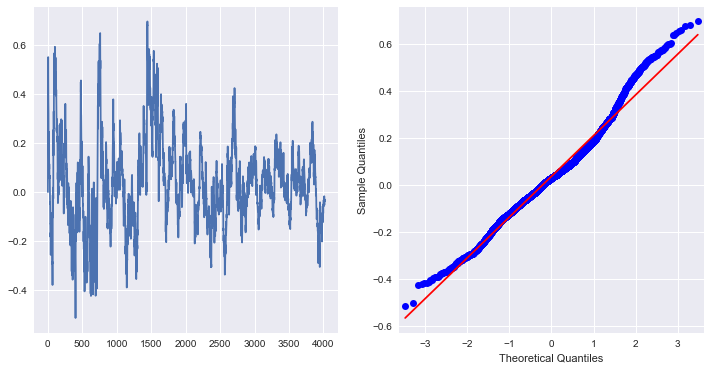

In [348]:
import statsmodels.api as sm
import scipy.stats as stats
fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(diff)
fig = sm.qqplot(diff, stats.distributions.norm, line='r', ax=ax[1]) 

In [112]:
# regression on time

no = range(0,4019)
DateNo = pd.DataFrame(no,columns=['DateNo'])
df2 = pd.concat([DateNo,JPY],axis=1)
df2.columns.values[1]='JPY'
df2.head()

,DateNo,JPY
0,0,240.30
1,1,238.45
2,2,238.35
3,3,234.80
4,4,231.55


In [118]:
lmfit = smf.ols('JPY ~ DateNo',data=df2).fit()
lmfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    JPY   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                 1.835e+04
Date:                Wed, 15 Nov 2017   Prob (F-statistic):               0.00
Time:                        10:31:46   Log-Likelihood:                -18354.
No. Observations:                4019   AIC:                         3.671e+04
Df Residuals:                    4017   BIC:                         3.673e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    255.0535      0.735    347.140      0.000     253.613     256.494
DateNo        -0.0429      0.000   -135.480      0.000      -0.044      -0.042
==============================================================================
Omnibus:                       58.584   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.973
Skew:                           0.279   Prob(JB):                     1.56e-13
Kurtosis:                       2.799   Cond. No.                     4.64e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.64e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [139]:
#add month variables
Mon = []
for day in Date:
    a = day.month
    Mon.append(a)
Month = pd.DataFrame(Mon, columns=['Month'])
df3 = pd.concat([df2,Month],axis=1)


,DateNo,JPY,Month
0,0,240.30,12
1,1,238.45,1
2,2,238.35,1
3,3,234.80,1
4,4,231.55,1


In [141]:
lmfit2 = smf.ols('JPY ~ DateNo+C(Month)',data=df3).fit()
lmfit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    JPY   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     1535.
Date:                Wed, 15 Nov 2017   Prob (F-statistic):               0.00
Time:                        11:14:09   Log-Likelihood:                -18344.
No. Observations:                4019   AIC:                         3.671e+04
Df Residuals:                    4006   BIC:                         3.680e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        252.5282      1.415    178.491      0.000     249.754     255.302
C(Month)[T.2]      0.6624      1.855      0.357      0.721      -2.975       4.300
C(Month)[T.3]      1.8022      1.782      1.011      0.312      -1.691       5.296
C(Month)[T.4]      2.0698      1.797      1.152      0.249      -1.453       5.592
C(Month)[T.5]      1.1852      1.805      0.657      0.511      -2.353       4.724
C(Month)[T.6]      2.6105      1.796      1.454      0.146      -0.910       6.131
C(Month)[T.7]      4.2071      1.800      2.338      0.019       0.679       7.735
C(Month)[T.8]      5.8533      1.784      3.281      0.001       2.356       9.351
C(Month)[T.9]      5.0244      1.818      2.764      0.006       1.461       8.588
C(Month)[T.10]     3.3991      1.806      1.883      0.060      -0.141       6.939
C(Month)[T.11]     2.9932      1.848      1.620      0.105      -0.630       6.616
C(Month)[T.12]     1.5242      1.799      0.847      0.397      -2.004       5.052
DateNo            -0.0430      0.000   -135.531      0.000      -0.044      -0.042
==============================================================================
Omnibus:                       57.206   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.722
Skew:                           0.277   Prob(JB):                     2.92e-13
Kurtosis:                       2.807   Cond. No.                     2.92e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.92e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [147]:
print lmfit2.ssr

2168045.95088


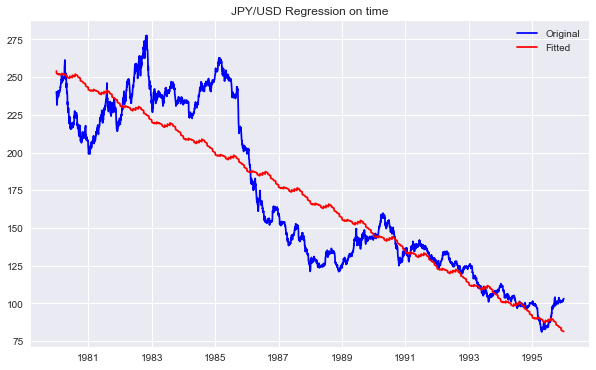

In [145]:
#plot 
yfitted = lmfit2.fittedvalues

fig = plt.figure(figsize=(10,6))
orig = plt.plot(Date,JPY, color='blue',label='Original')
fitted = plt.plot(Date,yfitted, color='red', label='Fitted')
plt.legend(loc='best')
plt.title('JPY/USD Regression on time')
plt.show()


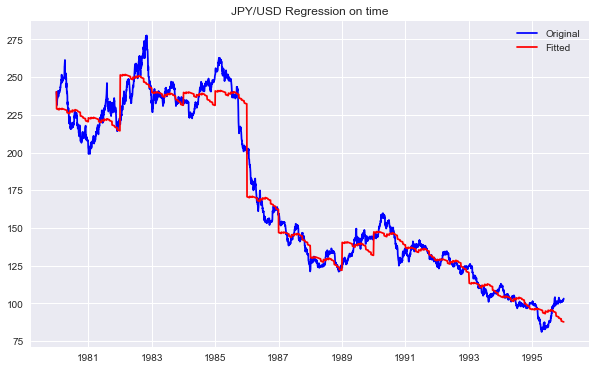

In [146]:
#add year variables
Year = []
for day in Date:
    a = day.year
    Year.append(a)
Year = pd.DataFrame(Year, columns=['Year'])
df4 = pd.concat([df3,Year],axis=1)
lmfit3 = smf.ols('JPY ~ DateNo+C(Month)+C(Year)',data=df4).fit()
lmfit3.summary()

#plot 
yfitted = lmfit3.fittedvalues

fig = plt.figure(figsize=(10,6))
orig = plt.plot(Date,JPY, color='blue',label='Original')
fitted = plt.plot(Date,yfitted, color='red', label='Fitted')
plt.legend(loc='best')
plt.title('JPY/USD Regression on time')
plt.show()


357374.267439
